# Tutorial 05: Homework

### Assignement
  * For the attached data (cleaned data from the 3rd tutorial) try to use linear regression (or ridge regression, if you will) AND decision tree regressor (or boosted tree) applied on features given by PCA.
  * Try to select as less as possible features so that the results are comparably good (in terms of RMSLE) to the results obtained in the 3rd tutorial (RMSLE around 0.12).
  * Experiment with the feature selection:
    * Has removing indicator or discrete features a positive influence?
    * Are the first principal components always the best choice?

# Řešení

In [103]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, recall_score
import operator
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Nahrání dat a získání testovací a tréninkové sady
data = pd.read_csv('dataHW05.csv', index_col=0)
dtrain, dtest = train_test_split(data, test_size=0.25, random_state=458)
X = dtrain.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dtrain.SalePrice
Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
ytest = dtest.SalePrice

## Funkce pro testování
Nejdříve napíši jednoduchou funkci, která bude provádět test PCA. Testovat budu jak počet využitých komponent, tak jednotlivé modely (LinearRegresion, DecisionTreeRegression). Veškeré výsledky se pokusím vizualizovat, aby bylo jasné, jak využívání jednotlivých počtů komponent pomohlo k výsledné minimální chybě.

In [27]:
# Funkce pro testování škálované a neškálované PCA pro různý počet komponent
def pcaTest(data, modelBase, modelScale, minComponents = 2, maxComponents = 50):
    # Rozdělení dat
    dtrain, dtest = train_test_split(data, test_size=0.25, random_state=458)
    X = dtrain.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = dtrain.SalePrice
    Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
    ytest = dtest.SalePrice
    
    # RMLSE
    modelBase.fit(X, y)
    baseScore = np.sqrt(mean_squared_error(modelBase.predict(Xtest), ytest))
    
    # Získání PCA hodnot
    scores_base = []
    scores_scale = []
    min_base = 1
    min_scale = 1
    
    for components in range(minComponents, maxComponents):
        pca = PCA(n_components=components)
        #Bez škálování
        pca.fit_transform(X)
        XBase = pca.transform(X)
        XtestBase = pca.transform(Xtest)
        #Se škálováním
        pca.fit_transform(scale(X))
        XScale = pca.transform(scale(X))
        XtestScale = pca.transform(scale(Xtest))
        #Naučení modelu
        model_base = modelBase.fit(XBase, y)
        model_scale = modelScale.fit(XScale, y)
        #RMLSE
        score_base = np.sqrt(mean_squared_error(model_base.predict(XtestBase), ytest))
        score_scale = np.sqrt(mean_squared_error(model_scale.predict(XtestScale), ytest))
        scores_base.append(score_base)
        scores_scale.append(score_scale)
        # Nastaveni maxim
        if (score_base < min_base):
            min_base = score_base
        if (score_scale < min_scale):
            min_scale = score_scale
     
    min_score = min(min_base, min_scale)
    return baseScore, scores_base, scores_scale, min_score

def printGraph(ax, low_line, data, minX, maxX, title):
    p1 = ax.plot(range(minX, maxX), data[1], color=(0,0.3,0.5,0.5))
    p2 = ax.plot(range(minX, maxX), data[2], color=(0,0,0.6,0.5))
    l1 = ax.plot([minX, maxX], [data[0], data[0]], c='red')
    l2 = ax.fill_between([minX, maxX], 0, low_line + 0.03, facecolor=(0,1,0,0.3))
    ax.set_title(title)
    ax.set_xlabel('Počet užitých komponent PCA')
    ax.set_ylabel('RMSLE')
    ax.legend(['hodnota RMLSE bez PCA','neškálované', 'škálované', 'optimum (požadujeme)',])

def printResults(low_line, data1, data2, minX, maxX):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
    printGraph(axes[0], low_line, data1, minX, maxX, "Lineární regrese")
    printGraph(axes[1], low_line, data2, minX, maxX, "Rozhodovací strom")
    fig.suptitle("Přehled naměřených hodnot RMLSE pro počet užitých komponent PCA", size=20)
    fig.show()    

## První spuštění
Otestuji nejdříve původní data bez žádného předzpracování pro možnosti budoucího porovnání. Z výsledku je možné vidět, že se ani s využitím PCA nejsme schopni přiblížit chtěnému optimu ~ 0.12

Minimální chyba lieární regrese: 	0.17782183105193128
Minimální chyba rozhodovacího stromu: 	0.20469930808011913



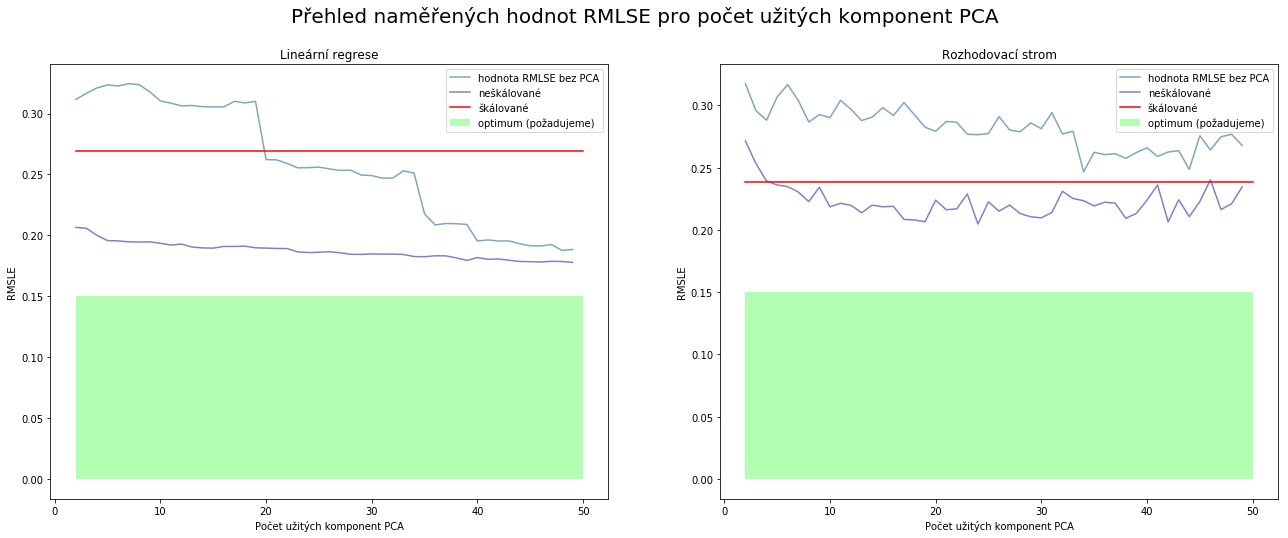

In [28]:
test1 = pcaTest(data, LinearRegression(), LinearRegression(), 2, 50)
test2 = pcaTest(data, DecisionTreeRegressor(random_state=458),DecisionTreeRegressor(random_state=458), 2, 50)
print('Minimální chyba lieární regrese: \t' + str(test1[3]))
print('Minimální chyba rozhodovacího stromu: \t' + str(test2[3]))
print() 
printResults(0.12, test1, test2, 2, 50)

## Data bez diskrétních hodnot a id
Zkusím odstranit všechny features, které mají málo unikátních hodnot (chovají se jako hodnoty diskrétní) společně s indikátorem = id.

In [48]:
data2 = data.copy()
data_noId = data2.drop(columns=['Id'])
dis = []

#Nalezení diskrétních hodnot
for col in data2.columns:
    if (len(data2[col].unique()) < 10):
        dis.append(col)

#Smazání sloupců
data2 = data2.drop(columns=dis)
print("Počet nalezených diskrétních sloupců:" + str(len(dis)))

#Smazání id
data2_noId = data2.drop(columns=['Id'])

Počet nalezených diskrétních sloupců:275


### Data bez diskrétních hodnot
Na naměřeneých datech vidíme, že odstranění diskrétních hodnot nemělo pozitivní vliv ani na jeden z modelů. 

Minimální chyba lieární regrese: 	0.18659760965947325
Minimální chyba rozhodovacího stromu: 	0.21984289917243297



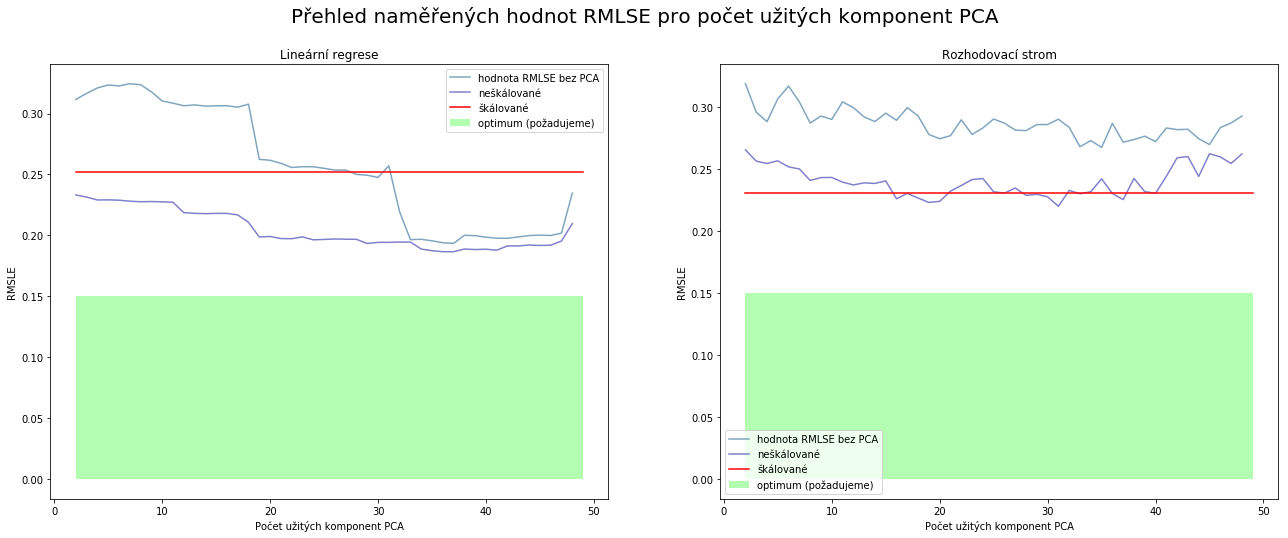

In [49]:
test3a = pcaTest(data2, LinearRegression(), LinearRegression(), 2, 49)
test3b = pcaTest(data2, DecisionTreeRegressor(random_state=458),DecisionTreeRegressor(random_state=458), 2, 49)
print('Minimální chyba lieární regrese: \t' + str(test3a[3]))
print('Minimální chyba rozhodovacího stromu: \t' + str(test3b[3]))
print()
printResults(0.12, test3a, test3b, 2, 49)

### Data bez Id
Na naměřených datech vidíme, že výraznější vliv je pouze na Rozhodovací strom, který zaznamenal na středním počtu komponent zlepšení.

Minimální chyba lieární regrese: 	0.17758370657848732
Minimální chyba rozhodovacího stromu: 	0.20026967735826148



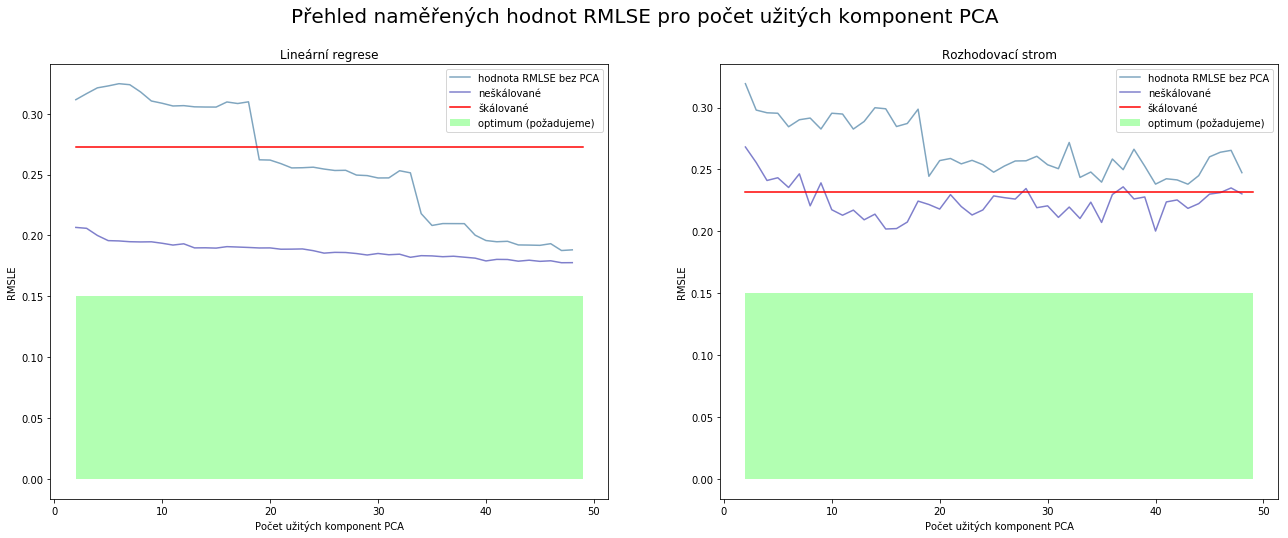

In [50]:
test3a = pcaTest(data_noId, LinearRegression(), LinearRegression(), 2, 49)
test3b = pcaTest(data_noId, DecisionTreeRegressor(random_state=458),DecisionTreeRegressor(random_state=458), 2, 49)
print('Minimální chyba lieární regrese: \t' + str(test3a[3]))
print('Minimální chyba rozhodovacího stromu: \t' + str(test3b[3]))
print()
printResults(0.12, test3a, test3b, 2, 49)

### Data bez unikátních hodnot a id
Dle očekávání kombinace obojího zhoršila vlastnosti obou modelů.

Minimální chyba lieární regrese: 	0.18658473312595383
Minimální chyba rozhodovacího stromu: 	0.21657823664351042



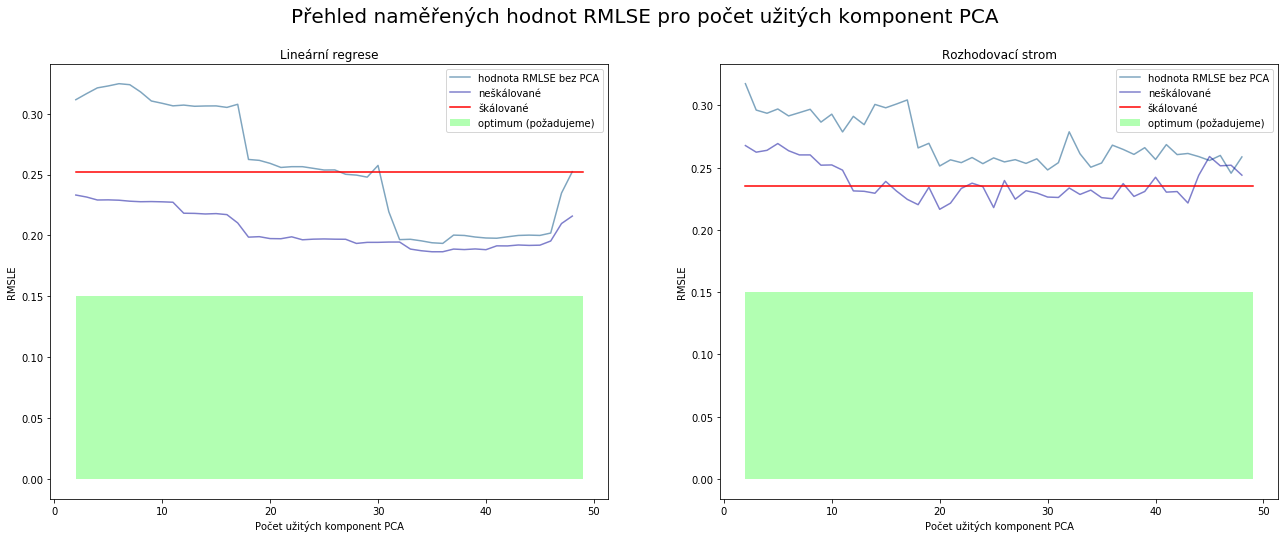

In [52]:
test3a = pcaTest(data2_noId, LinearRegression(), LinearRegression(), 2, 49)
test3b = pcaTest(data2_noId, DecisionTreeRegressor(random_state=458),DecisionTreeRegressor(random_state=458), 2, 49)
print('Minimální chyba lieární regrese: \t' + str(test3a[3]))
print('Minimální chyba rozhodovacího stromu: \t' + str(test3b[3]))
print()
printResults(0.12, test3a, test3b, 2, 49)

## Odtranění outlierů
Tak jako u všech ostatních cvičení by mělo být odtranění outlierů pozitivním krokem k vylepšení vlastností lineární regrese bez ohledu na použití PCA. Zkusme proto odstranit outliery ze všech 
sloupců a uvividíme, zdali tento krok pomůže.

In [85]:
# Nalezení outlierů metodou kvantilů
def findOutliers(data, col, bottom = 0.25, top = 0.80):
    bd_Q1 = data[col].quantile(bottom)
    bd_Q3 = data[col].quantile(top)
    bd_IQR =  bd_Q3 - bd_Q1
    
    bdOut = (data[col] < bd_Q1 - 1.5 * bd_IQR)
    return data[bdOut].index

def deleteOutliers(data, bottom=0.25, top=0.75):
    outliers = {}
    data3 = data.copy()
    for col in data3.columns:
        out = findOutliers(data3, col, bottom, top)
        if (len(out) > 0):
            data3.drop(inplace=True, index=out)
            outliers[col] = out

    display(outliers)
    return data3

### Data bez diskrétních hodnot a id
Vidíme, že odstranění outlierů má vliv na oba modely, převážně však hlavně na lineární regresi, která zaznamená velmi dobré výsledky, které se již přibližují 0.12, nicméně stejně tak vidíme, že došlo hlavně ke zlepšení vlastností modelu, pro zlepšení lineární regrese společně s využitím PCA je potřeba mnoho komponent.

In [69]:
data3 = deleteOutliers(data2_noId)

{'GarageYrBlt': Int64Index([  48,   78,   88,   89,   99,  108,  125,  127,  140,  148,  155,
              163,  165,  198,  210,  241,  250,  287,  291,  307,  386,  393,
              431,  434,  441,  464,  495,  528,  535,  562,  582,  613,  614,
              620,  635,  636,  638,  649,  710,  738,  750,  784,  826,  843,
              921,  942,  954,  960,  968,  970,  976, 1009, 1030, 1038, 1096,
             1123, 1131, 1143, 1173, 1219, 1234, 1257, 1283, 1323, 1325, 1326,
             1337, 1407, 1449, 1450, 1453],
            dtype='int64'),
 'LogBsmtUnfSF': Int64Index([  42,   52,   53,   54,   81,  120,  174,  188,  202,  233,  251,
              260,  262,  263,  273,  293,  303,  306,  322,  352,  372,  373,
              411,  420,  426,  461,  470,  545,  548,  557,  569,  574,  586,
              592,  598,  634,  643,  663,  696,  764,  771,  779,  783,  786,
              807,  810,  828,  845,  856,  863,  924,  945,  953, 1024, 1059,
             1067, 1098, 110

In [93]:
data4.shape

(1120, 52)

Minimální chyba lieární regrese: 	0.1437691124375911
Minimální chyba rozhodovacího stromu: 	0.1872182065740452



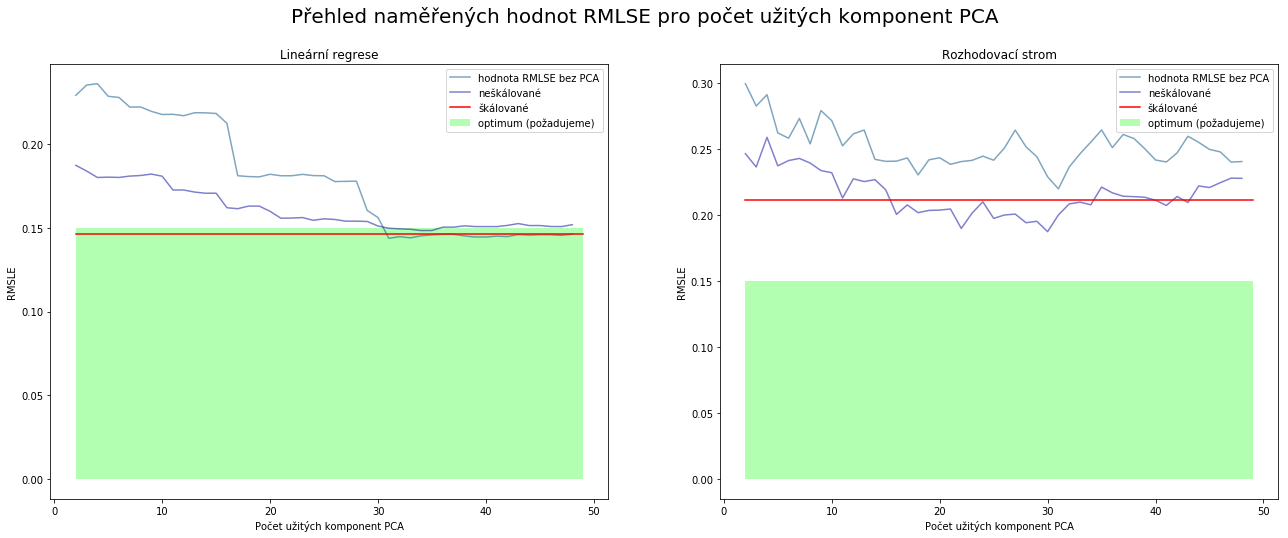

In [70]:
#Spuštění PCA testu
test4a = pcaTest(data3, LinearRegression(), LinearRegression(), 2, 49)
test4b = pcaTest(data3, DecisionTreeRegressor(random_state=458),DecisionTreeRegressor(random_state=458), 2, 49)
print('Minimální chyba lieární regrese: \t' + str(test4a[3]))
print('Minimální chyba rozhodovacího stromu: \t' + str(test4b[3]))
print()
printResults(0.12, test4a, test4b, 2, 49)

Na výsledcích si můžeme všimnout, že opravdu došlo ke zlepšení lineární regrese i decision tree. Lineární regrese nyní dosahuje hodnot pod 0.15, což je výsledek, kterého jsme chtěli dosáhnout. Zkusme postup opakovat, nyní ovšem 

### Data bez diskrétních hodnot
Pouze pro data bez diskrétních hodnot nedojde k téměř žádnému vylepšení rozhodovacího stromu. U rozhodovacího stromu pro nás zároveň spolešně s ponecháním id (jak je vidět z grafu) téměř ztrácí smysl využívat PCA, jelikož většina hodnot zůstává nad přímkou, která označuje původní hodnotu RMSLE bez využití PCA. Lineární regrese se chová téměř stejně jako když jsme odtranili i id.

In [94]:
data4 = deleteOutliers(data2)

{'GarageYrBlt': Int64Index([  48,   78,   88,   89,   99,  108,  125,  127,  140,  148,  155,
              163,  165,  198,  210,  241,  250,  287,  291,  307,  386,  393,
              431,  434,  441,  464,  495,  528,  535,  562,  582,  613,  614,
              620,  635,  636,  638,  649,  710,  738,  750,  784,  826,  843,
              921,  942,  954,  960,  968,  970,  976, 1009, 1030, 1038, 1096,
             1123, 1131, 1143, 1173, 1219, 1234, 1257, 1283, 1323, 1325, 1326,
             1337, 1407, 1449, 1450, 1453],
            dtype='int64'),
 'LogBsmtUnfSF': Int64Index([  42,   52,   53,   54,   81,  120,  174,  188,  202,  233,  251,
              260,  262,  263,  273,  293,  303,  306,  322,  352,  372,  373,
              411,  420,  426,  461,  470,  545,  548,  557,  569,  574,  586,
              592,  598,  634,  643,  663,  696,  764,  771,  779,  783,  786,
              807,  810,  828,  845,  856,  863,  924,  945,  953, 1024, 1059,
             1067, 1098, 110

Minimální chyba lieární regrese: 	0.14374485719470007
Minimální chyba rozhodovacího stromu: 	0.20080757789055562



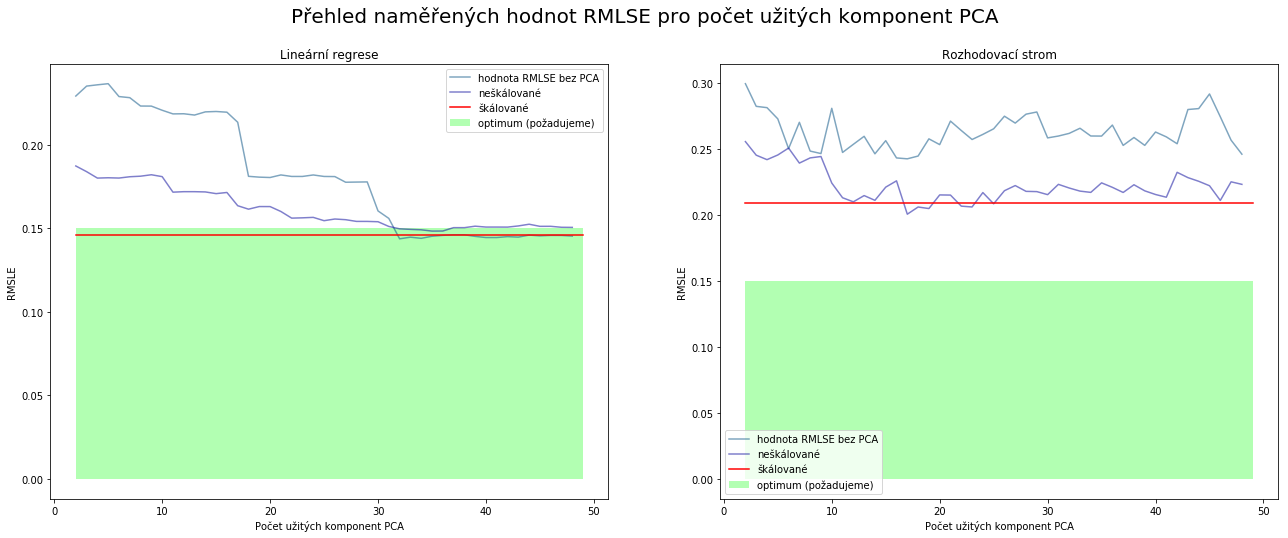

In [95]:
#Spuštění PCA testu
test5a = pcaTest(data4, LinearRegression(), LinearRegression(), 2, 49)
test5b = pcaTest(data4, DecisionTreeRegressor(random_state=458),DecisionTreeRegressor(random_state=458), 2, 49)
print('Minimální chyba lieární regrese: \t' + str(test5a[3]))
print('Minimální chyba rozhodovacího stromu: \t' + str(test5b[3]))
print()
printResults(0.12, test5a, test5b, 2, 49)

## Výběr 10 nejlepších sloupců
Nyní zkusím z půsovdních dat vybrat 10 těch, pro které jsou výsledné hodnoty RMLSE společně s PCA nejnižší

In [122]:
errorsL = {}
errorsD = {}

for col in data_noId.drop(columns=['SalePrice']).columns:
    cols = [col, "SalePrice"]
    errorL = pcaTest(data_noId[cols], LinearRegression(), LinearRegression(), 1, 2)
    errorD = pcaTest(data_noId[cols], DecisionTreeRegressor(random_state=458),DecisionTreeRegressor(random_state=458), 1, 2)
    errorsL[col] = errorL[3]
    errorsD[col] = errorD[3]
    
errorsL = sorted(errorsL.items(), key=operator.itemgetter(1))
errorsD = sorted(errorsD.items(), key=operator.itemgetter(1))
colsL = []
colsD = []
print("Lineární regrese:")
for error in errorsL[:10]:
    colsL.append(error[0])
    display(error[0] + " Chyba: " + str(error[1]))
 
print("Rozhodovací strom:")
for error in errorsD[:10]:
    colsD.append(error[0])
    display(error[0] + " Chyba: " + str(error[1]))

Lineární regrese:


'OverallQual Chyba: 0.24463007278236118'

'LogGrLivArea Chyba: 0.2833533822081535'

'GarageCars Chyba: 0.28900216586129596'

'SqrtGrLivArea Chyba: 0.29013354098879096'

'ExterQual_TA Chyba: 0.3036757225984868'

'GarageArea Chyba: 0.3040200152021558'

'GrLivArea Chyba: 0.30504747468575283'

'SqrtGarageArea Chyba: 0.31811331514045194'

'FullBath Chyba: 0.3294980711835098'

'KitchenQual_TA Chyba: 0.3312127797072059'

Rozhodovací strom:


'OverallQual Chyba: 0.24489639595970963'

'GarageCars Chyba: 0.27938784587437604'

'ExterQual_TA Chyba: 0.30395588514655275'

'YearBuilt Chyba: 0.31651939276393826'

'LogGarageArea Chyba: 0.31995920906776687'

'SqrtGarageArea Chyba: 0.31995920906776687'

'GarageYrBlt Chyba: 0.32202472090571527'

'GarageArea Chyba: 0.3241028643721621'

'MSSubClass Chyba: 0.3269332714254437'

'FullBath Chyba: 0.32852807206482065'

Z naměřených hodnot vidíme, že ani pro jednotlivé sloupce nedosáhneme požadované hodnoty, při kombinaci pouze 10 z nich je zřejmé, že nedostaneme požadované výsledky.

Minimální chyba lieární regrese: 	0.20534168686604598
Minimální chyba rozhodovacího stromu: 	0.2554288932728656



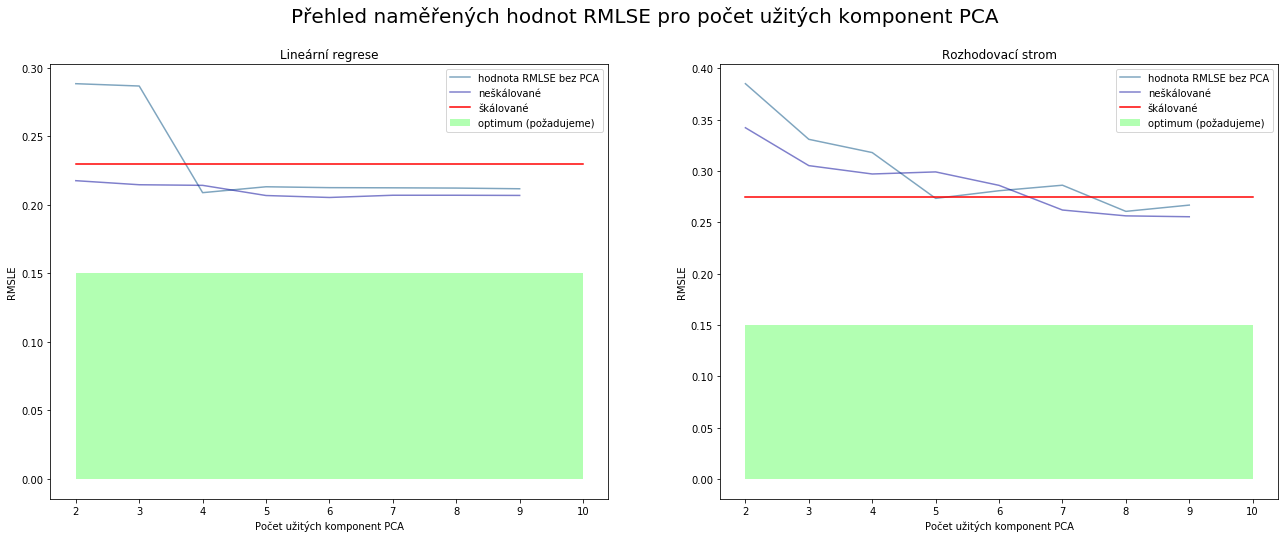

In [123]:
#Spuštění PCA testu
colsL.append('SalePrice')
colsD.append('SalePrice')

test7a = pcaTest(data_noId[colsL], LinearRegression(), LinearRegression(), 2, 10)
test7b = pcaTest(data_noId[colsD], DecisionTreeRegressor(random_state=458),DecisionTreeRegressor(random_state=458), 2, 10)
print('Minimální chyba lieární regrese: \t' + str(test7a[3]))
print('Minimální chyba rozhodovacího stromu: \t' + str(test7b[3]))
print()
printResults(0.12, test7a, test7b, 2, 10)

Z mého snažení je viditelné, že se mi výrazněji nepodařilo ovlivnit výsledky rozhodovacího stromu. Bohužel mě nenapadla selekce sloupců taková, aby došlo k výraznému zlepšení vlastností. 

Pro zlepšení lineární regrese stačilo odstranit outliery, čímž došlo i ke zlepšení výsedků po aplikaci PCA. 